In [1]:
from SimPEG import Mesh, Maps, Utils
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemFD, GlobalEM1DSurveyFD, get_vertical_discretization_frequency
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import SimPEG

In [3]:
import h5py
import tarfile
import os
import shutil
def download_and_unzip_data(
    url = "https://storage.googleapis.com/simpeg/bookpurnong/bookpurnong_inversion.tar.gz"
):
    """
    Download the data from the storage bucket, unzip the tar file, return
    the directory where the data are
    """
    # download the data
    downloads = Utils.download(url)

    # directory where the downloaded files are
    directory = downloads.split(".")[0]

    # unzip the tarfile
    tar = tarfile.open(downloads, "r")
    tar.extractall()
    tar.close()

    return downloads, directory

In [4]:
# download the data
downloads, directory = download_and_unzip_data()

# Load resolve data
resolve = h5py.File(
    os.path.sep.join([directory, "booky_resolve.hdf5"]),
    "r"
)
river_path = resolve["river_path"].value    # River path
nskip = 1
nSounding = resolve["data"][::nskip, :].shape[0]    # the # of soundings

# Bird height from surface
b_height_resolve = (resolve["src_elevation"])[::nskip]

# fetch the frequencies we are considering
cpi_inds = [0, 2, 6, 8, 10]  # Indices for HCP in-phase
cpq_inds = [1, 3, 7, 9, 11]  # Indices for HCP quadrature
frequency_cp = resolve["frequency_cp"].value
xy = (resolve["xy"].value)[::nskip, :]
line = resolve['line'][::nskip]

file already exists, new file is called /Users/sgkang/Projects/simpegEM1D/notebooks/develop/bookpurnong_inversion.tar.gz
   saved to: /Users/sgkang/Projects/simpegEM1D/notebooks/develop/bookpurnong_inversion.tar.gz
Download completed!


In [5]:
data_cpi = resolve["data"][::nskip, cpi_inds].astype(float)
data_cpq = resolve["data"][::nskip, cpq_inds].astype(float)

# Seting up a 2D mesh and model

In [6]:
from scipy.constants import mu_0
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=1./50)
# survey parameters
rxOffset = 7.86  # tx-rx separation
n_sounding = xy.shape[0]
b_height_resolve = resolve["src_elevation"].value[::nskip]
topo_resolve = resolve["ground_elevation"].value[::nskip]
uniq_line = np.unique(line)
x = xy[:,0]
y = xy[:,1]
z = topo_resolve + b_height_resolve
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, topo_resolve].astype(float)
mapping = Maps.ExpMap(nP=int(n_sounding*hz.size))

survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "ppm",
    field_type = 'secondary',
    topo = topo    
)
prob = GlobalEM1DProblemFD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=2,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [7]:
m0 = np.ones(mapping.nP) * np.log(1./50)
pred = survey.dpred(m0)

In [8]:
DOBS = np.empty((prob.n_sounding, 2, survey.n_frequency))
DPRED = pred.reshape((prob.n_sounding, 2, survey.n_frequency))
for i_freq in range(frequency_cp.size):
    DOBS[:,0,i_freq] = data_cpi[:, i_freq]
    DOBS[:,1,i_freq] = data_cpq[:, i_freq]    

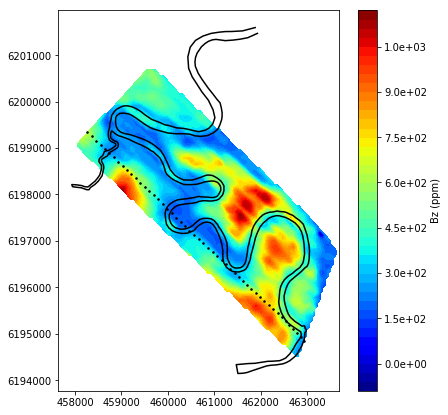

In [9]:
i_line = 3
ind_line = line == uniq_line[i_line]
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
out = Utils.plot2Ddata(xy, DOBS[:,0,0], scale='linear', contourOpts={'cmap':'jet', 'alpha':1}, ncontour=40, ax=ax)
# ax.plot(xy[:,0], xy[:,1], 'k.', ms=1)
ax.plot(river_path[:,0], river_path[:,1], 'k-')
cb = plt.colorbar(out[0], format="%.1e", ax=ax, fraction=0.05)
cb.set_label("Bz (ppm)")
ax.plot(xy[ind_line,0], xy[ind_line,1], 'k.', ms=3)
plt.show()

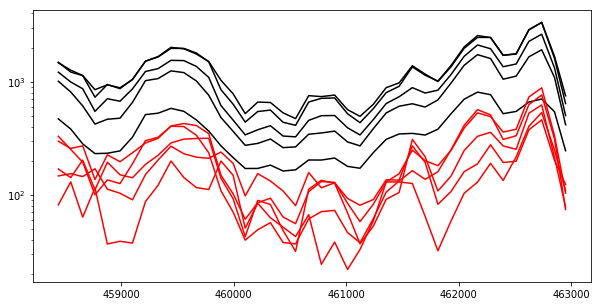

In [10]:
i_line = 4
ind_line = line == uniq_line[i_line]
figsize(10, 5)
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], DOBS[ind_line,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], DOBS[ind_line,1,i_freq], 'r')    

In [11]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

from simpegEM1D import get_2d_mesh, LateralConstraint

mesh_reg = get_2d_mesh(n_sounding, hz)
# Now we can create the regularization using the 2D mesh
reg = LateralConstraint(mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC))

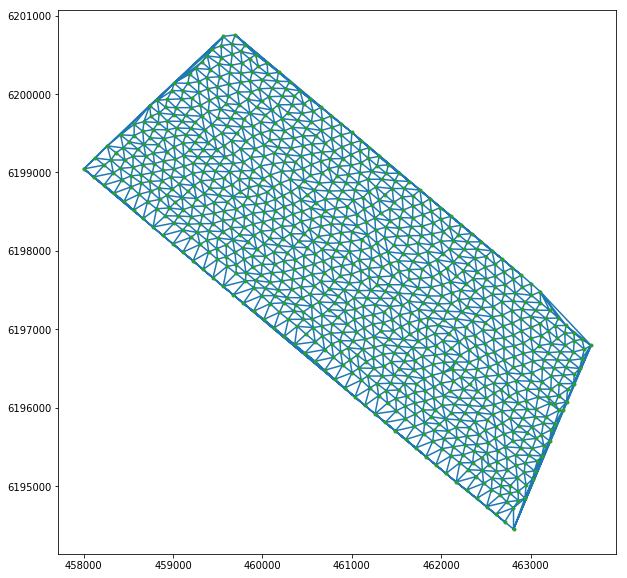

In [12]:
tri = reg.get_grad_horizontal(xy, hz)
figsize(10, 10)
plt.triplot(xy[:,0], xy[:,1], tri.simplices)
plt.plot(xy[:,0], xy[:,1], '.')
plt.show()

In [13]:
dobs = DOBS.flatten()

In [14]:
%%time
std = 0.1
floor = 20.
uncert = std*abs(dobs)+floor
survey.dobs = dobs
m0 = np.ones(mesh_reg.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
regmap = Maps.IdentityMap(mesh_reg)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh_reg, mapping=Maps.IdentityMap(nP=mesh_reg.nC),
    alpha_s=1.,
    alpha_x = 10.,
    alpha_y = 1.,        
)
tri = reg.get_grad_horizontal(xy, hz)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, betaSearch=False,
    chifact_start = 1
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.51e-02  1.91e+05  0.00e+00  1.91e+05    1.47e+03      0              
   1  4.26e-02  4.21e+04  6.96e+04  4.51e+04    4.88e+02      0              
   2  2.13e-02  3.22e+04  1.47e+05  3.53e+04    5.04e+02      0   Skip BFGS  
   3  1.06e-02  1.37e+04  1.43e+05  1.53e+04    4.19e+02      0              
   4  5.32e-03  5.19e+03  1.36e+05  5.91e+03    1.67e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld|

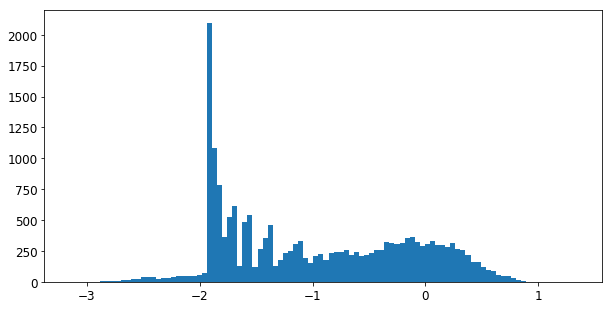

In [25]:
out = hist(np.log10(mapping*mopt), bins=100)

In [26]:
sigma = mapping * mopt

In [27]:
PRED = invProb.dpred.reshape((prob.n_sounding, 2, survey.n_frequency))

Text(0,0.5,'Hz (ppm)')

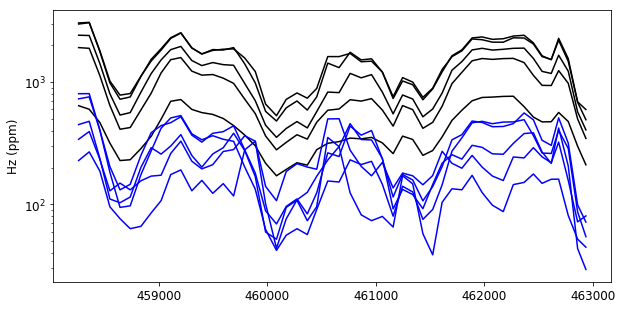

In [28]:
i_line = 3
ind_line = line == uniq_line[i_line]
figsize(10, 5)
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], DOBS[ind_line,0,i_freq], 'k')
#     plt.semilogy(xy[ind_line,0], PRED[ind_line,0,i_freq], 'k.')    
for i_freq in range(survey.n_frequency):
    plt.semilogy(xy[ind_line,0], DOBS[ind_line,1,i_freq], 'b')    
#     plt.semilogy(xy[ind_line,0], PRED[ind_line,1,i_freq], 'r.')      
plt.ylabel("Hz (ppm)")

# Final 3D mesh output

In [29]:
from simpegEM1D import set_mesh_1d
mesh_1d = set_mesh_1d(hz)
depth = -mesh_1d.gridN[:-1]
xyz = np.empty((hz.size, xy.shape[0], 3), order='F')
for i_xy in range(xy.shape[0]):
    z = - mesh_1d.vectorCCx + topo[i_xy, 2]
    x = np.ones_like(z) * xy[i_xy,0]
    y = np.ones_like(z) * xy[i_xy,1]
    xyz[:, i_xy, :] = np.c_[x, y, z]

In [30]:
Sigma = sigma.reshape((hz.size, n_sounding), order='F')
# Sigma_l2 = sigma_l2.reshape((hz.size, n_sounding), order='F')

In [31]:
xmin, xmax = xy[:,0].min(), xy[:,0].max()
ymin, ymax = xy[:,1].min(), xy[:,1].max()
zmin, zmax = topo[:,2].min() + depth.min(), topo[:,2].max()

In [32]:
import matplotlib
matplotlib.rcParams['font.size'] = 12

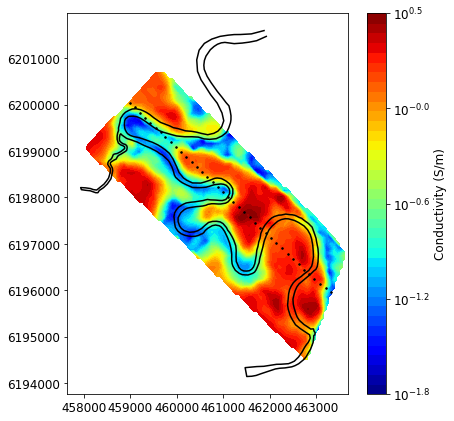

In [33]:
iz = 2
i_line = 13
ind_line = line == uniq_line[i_line]
xz = xyz[:, ind_line, :][:,:,[0,2]].reshape((int(hz.size*ind_line.sum()), 2), order='F')
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
temp = sigma.reshape((mesh_reg.vnC), order='F')[iz,:]
out = Utils.plot2Ddata(xy, temp, scale='log', contourOpts={'cmap':'jet', 'alpha':1}, ncontour=40, ax=ax)
# ax.plot(xy[:,0], xy[:,1], 'k.', ms=1)
ax.plot(river_path[:,0], river_path[:,1], 'k-')
vmin, vmax = out[0].get_clim()
cb = plt.colorbar(out[0], format="$10^{%.1f}$", ax=ax, fraction=0.05, ticks=np.linspace(vmin, vmax,5))
cb.set_label("Conductivity (S/m)")
ax.plot(xy[ind_line,0], xy[ind_line,1], 'k.', ms=3)
plt.show()

<Figure size 720x360 with 0 Axes>

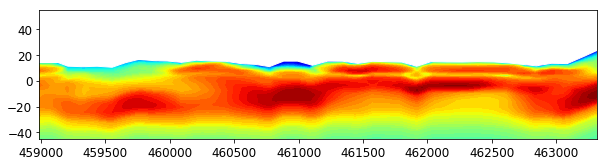

In [34]:
fig = plt.figure()
sigma_xz = Utils.mkvc(Sigma[:,ind_line])
Utils.plot2Ddata(xz, sigma_xz, scale='log', dataloc=False, contourOpts={'cmap':'jet'}, ncontour=50)
plt.fill_between(topo[ind_line, 0], topo[ind_line, 2], topo[ind_line, 1]*0. + zmax, color='w')
plt.ylim(zmax-100, zmax)
plt.gca().set_aspect(10)